In [35]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.stats import pearsonr

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_selection import mutual_info_classif
import os
from cnmf import cNMF, save_df_to_npz, load_df_from_npz
import harmonypy
from adjustText import adjust_text

from matplotlib.patches import Patch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
from matplotlib.pyplot import rc_context
from starcat import starCAT

def save_df_to_text(obj, filename):
    obj.to_csv(filename, sep='\t')


In [6]:
sys.path.append('../../../Code/')
from utils import read_dataset_log

In [7]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params = params[params['dataset_type']=='discovery']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,manual_gating_fn,manual_activation_gating_fn,activation_score_fn,metadata_fn,...,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label,tcat_fn_old
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Activa...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,...,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Ac...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,...,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...,/data/srlab1/TCAT/Data/PerDataset/TBRU/Activat...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,...,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Acti...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,...,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,...,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCA

In [19]:
fn = params.loc['Pan-Cancer', 'processed_forcnmf_fn'][:-5]+'.WithUMAP.h5ad'
fn

'/data/srlab1/TCAT/Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.WithUMAP.h5ad'

In [20]:
adata = sc.read(fn)

Only considering the two last: ['.WithUMAP', '.h5ad'].
Only considering the two last: ['.WithUMAP', '.h5ad'].


In [26]:
adata.obs.head()

,patient,cellID,libraryID,cancerType,loc,batchV,TCR,dataset,ClusterID,dataset.tech,...,DIG.Score1,score.MALAT1,percent.mito,miniCluster,meta.cluster,meta.cluster.coarse,ClusterID.harmony,batch,n_counts,leiden
bcc.su001.pre.tcell_AAACGGGTCATACGGT-0,su001,bcc.su001.pre.tcell_AAACGGGTCATACGGT,bcc.su001.pre.tcell,BCC,T,su001,NaN,BCC.KathrynEYost2019,BCC.KathrynEYost2019.C20,KathrynEYost2019,...,2.268873,5.245718,NaN,BCC.KathrynEYost2019.C0148,CD4.c01.Tn.TCF7,CD4.c01.Tn.LEF1,C09,0,2556.0,9
bcc.su001.pre.tcell_AAAGATGGTTTGGGCC-0,su001,bcc.su001.pre.tcell_AAAGATGGTTTGGGCC,bcc.su001.pre.tcell,BCC,T,su001,NaN,BCC.KathrynEYost2019,BCC.KathrynEYost2019.C20,KathrynEYost2019,...,0.839407,3.802175,NaN,BCC.KathrynEYost2019.C0106,CD4.c06.Tm.ANXA1,CD4.c02.Tm.ANXA1,C00,0,4876.0,7
bcc.su001.pre.tcell_AAAGCAAAGCAGGTCA-0,su001,bcc.su001.pre.tcell_AAAGCAAAGCAGGTCA,bcc.su001.pre.tcell,BCC,T,su001,NaN,BCC.KathrynEYost2019,BCC.KathrynEYost2019.C01,KathrynEYost2019,...,0.380237,4.793921,NaN,BCC.KathrynEYost2019.C0345,CD4.c14.Th17.SLC4A10,CD4.c02.Tm.ANXA1,C18,0,4302.0,8
bcc.su001.pre.tcell_AAAGTAGGTATATGAG-0,su001,bcc.su001.pre.tcell_AAAGTAGGTATATGAG,bcc.su001.pre.tcell,BCC,T,su001,NaN,BCC.KathrynEYost2019,BCC.KathrynEYost2019.C08,KathrynEYost2019,...,-0.091603,6.153880,NaN,BCC.KathrynEYost2019.C0011,CD4.c19.Treg.S1PR1,CD4.c08.Treg.FOXP3,C20,0,3271.0,3
bcc.su001.pre.tcell_AAAGTAGGTCTGCCAG-0,su001,bcc.su001.pre.tcell_AAAGTAGGTCTGCCAG,bcc.su001.pre.tcell,BCC,T,su001,NaN,BCC.KathrynEYost2019,BCC.KathrynEYost2019.C02,KathrynEYost2019,...,0.408059,5.268717,NaN,BCC.KathrynEYost2019.C0154,CD4.c20.Treg.TNFRSF9,CD4.c08.Treg.FOXP3,C01,0,8025.0,3


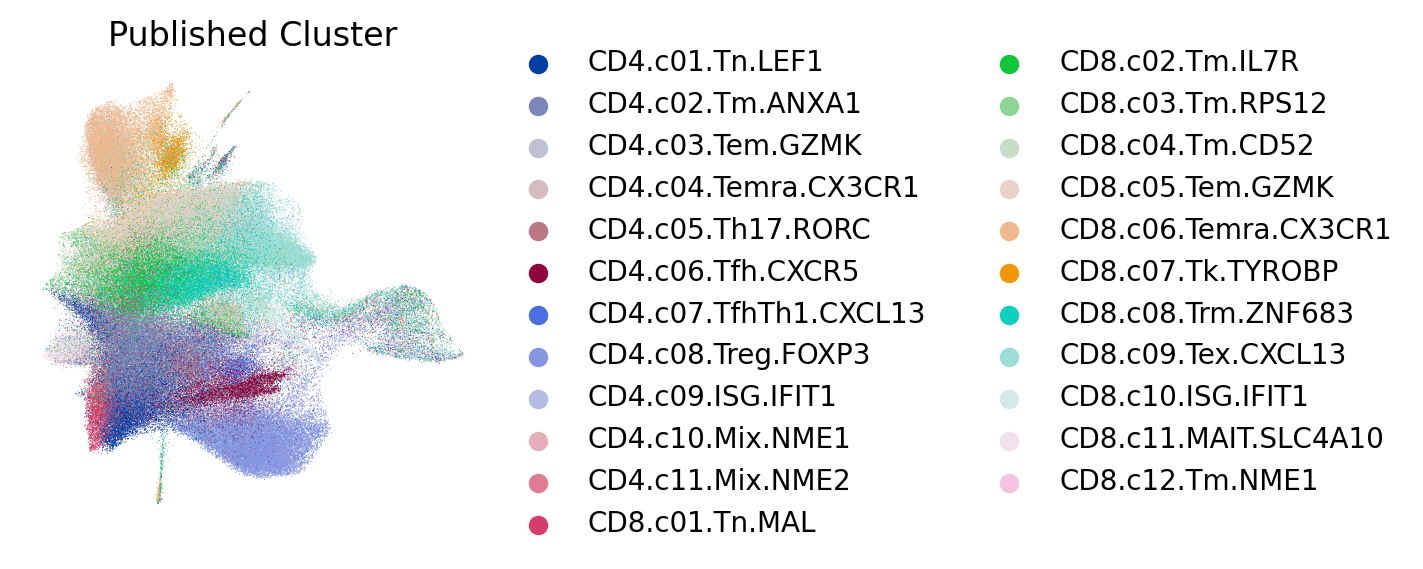

In [61]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
sc.pl.embedding(adata, basis='X_umap', color='meta.cluster.coarse', ax=ax, title='Published Cluster', frameon=False)

In [33]:
fn = params.loc['Pan-Cancer', 'raw_counts_filt_fn']
fn

'/data/srlab1/TCAT/Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927FiltForcNMF.h5ad'

In [34]:
adata_raw = sc.read(fn)

Only considering the two last: ['.20230927FiltForcNMF', '.h5ad'].
Only considering the two last: ['.20230927FiltForcNMF', '.h5ad'].


In [41]:
starmod = starCAT(reference='TCAT.V1', cachedir='../../../Data')

Using reference from starCAT database
Caching reference to ../../../Data/TCAT.V1


In [42]:
usages, scores = starmod.fit_transform(adata_raw)

3412 out of 3412 genes in the reference overlap with the query


/PHShome/dk718/miniforge3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [62]:
adata.obs['Exhaustion'] = usages['Exhaustion']>.0625
adata.obs['ISG'] = usages['ISG']>.0625
adata.obs['Proliferation'] = scores['Proliferation_binary']
adata.obs['Lineage Label'] = scores['Multinomial_Label']
adata.obs['Antigen specific activation'] = scores['ASA_binary']

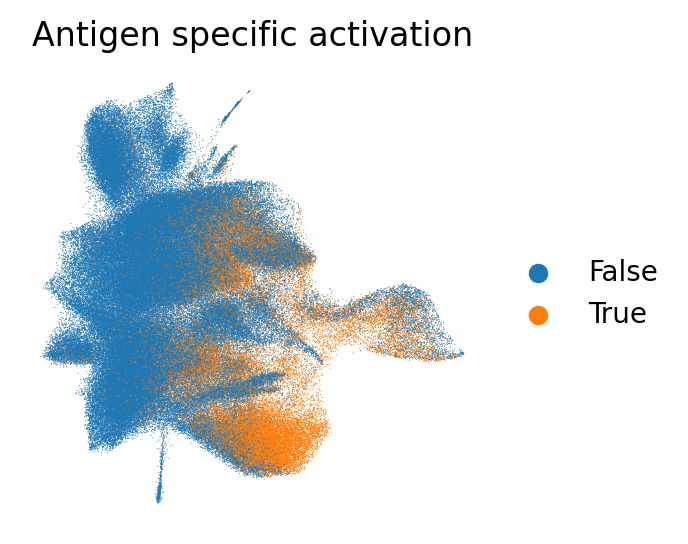

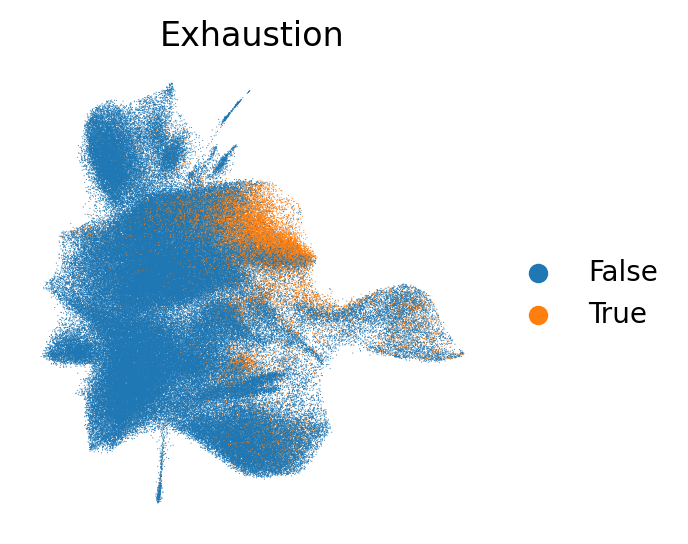

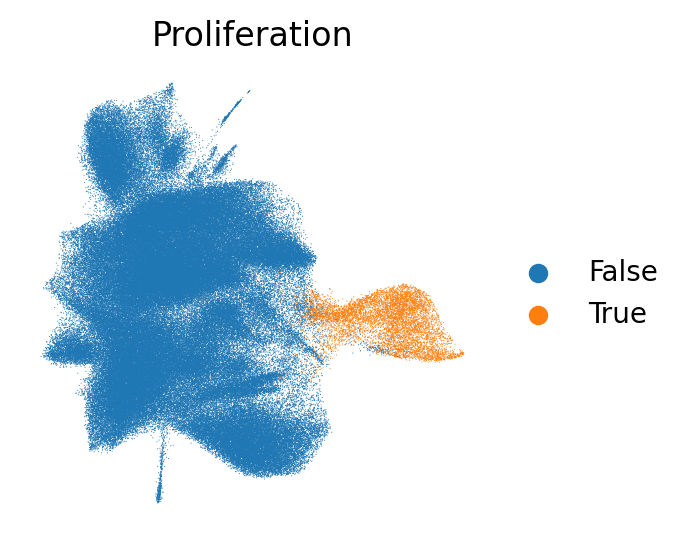

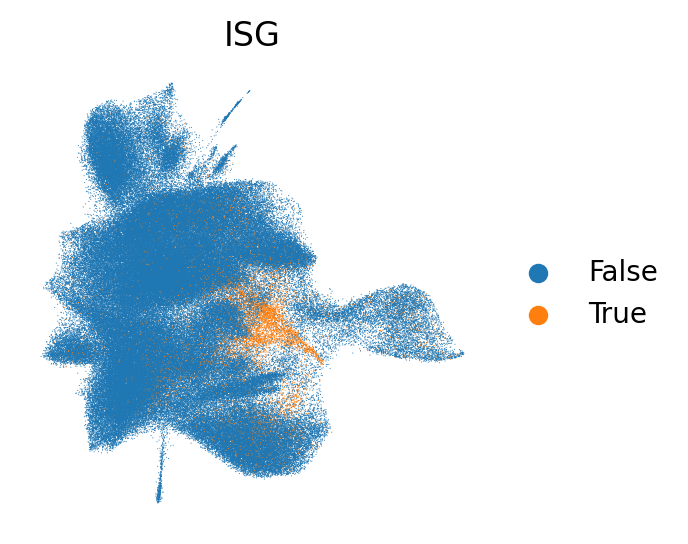

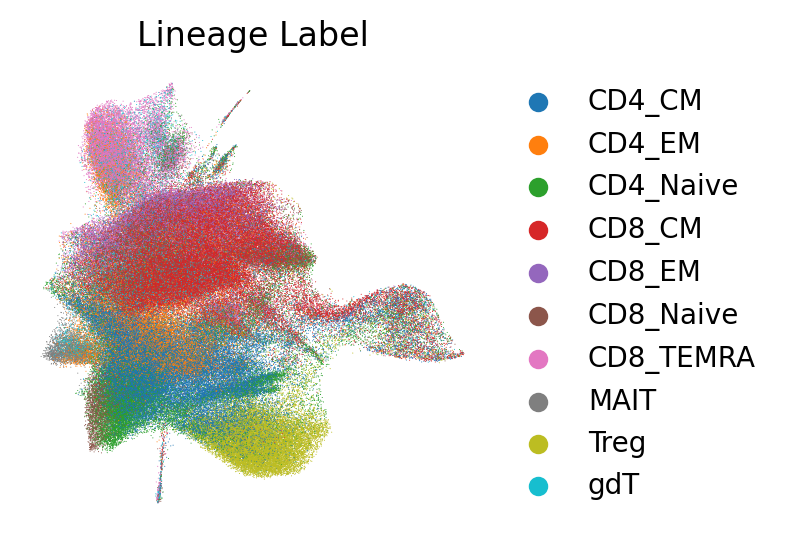

In [64]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
sc.pl.embedding(adata, basis='X_umap', color='Antigen specific activation', ax=ax, title='Antigen specific activation', frameon=False)

(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
sc.pl.embedding(adata, basis='X_umap', color='Exhaustion', ax=ax, title='Exhaustion', vmax='p99.9', frameon=False)

(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
sc.pl.embedding(adata, basis='X_umap', color='Proliferation', ax=ax, title='Proliferation', vmax='p99.9', frameon=False)

(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
sc.pl.embedding(adata, basis='X_umap', color='ISG', ax=ax, title='ISG', vmax='p99.9', frameon=False)

(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
sc.pl.embedding(adata, basis='X_umap', color='Lineage Label', ax=ax, title='Lineage Label', vmax='p99.9', frameon=False)

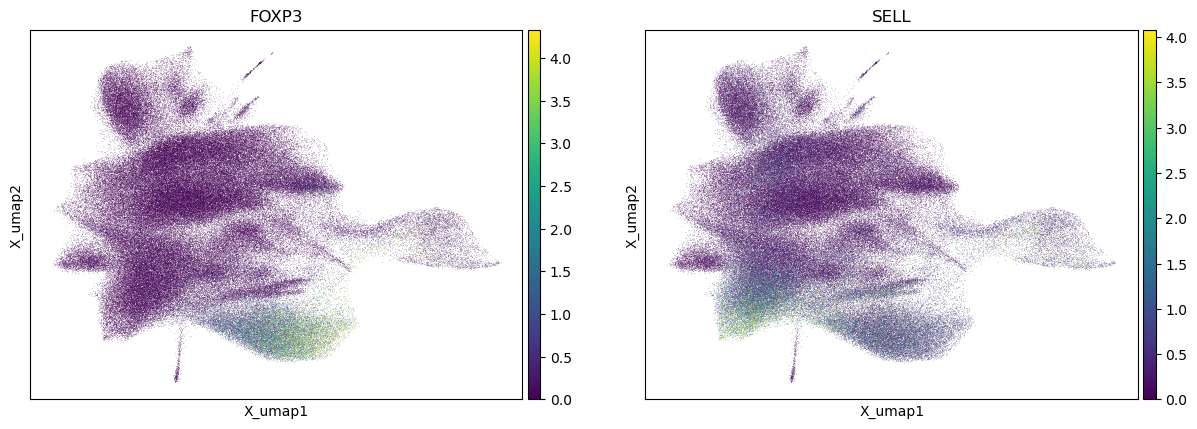

In [59]:
sc.pl.embedding(adata, basis='X_umap', color=['FOXP3', 'SELL'], vmax='p99')

In [40]:
! ls ../../../Data

Dataset_completion_log_20230828.xlsx  Misc	  Revision  TCAT
Dataset_completion_log.xlsx	      PerDataset  starCAT


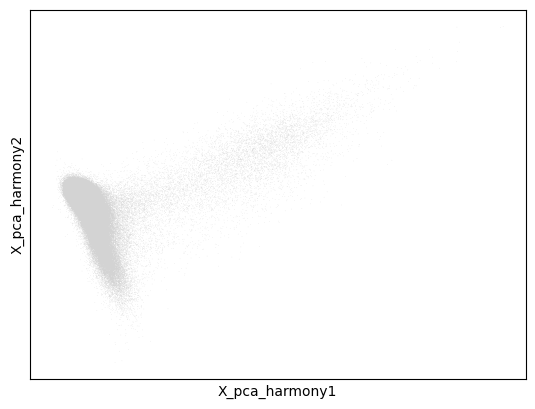

In [11]:
sc.pl.embedding(adata, basis='X_pca_harmony')